#Challenges 12: MongoDB

In [2]:
import pickle
from pprint import pprint
with open("heavy_metal_parsed.pkl", 'r') as datafile:
    heavy_metal_reviews = pickle.load(datafile)

In [5]:
# mongodb
from pymongo import MongoClient
client = MongoClient('mongodb://52.10.8.92:27017/')
client.heavy_metal_reviews.hm.remove()
metal = client.heavy_metal_reviews.h_m
for review in heavy_metal_reviews:
    metal.save(review)

#####Challenge 1
Make a histogram of the years in the data. How many metal movies came
out over the years?


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
years = [i['year'] for i in metal.find()]


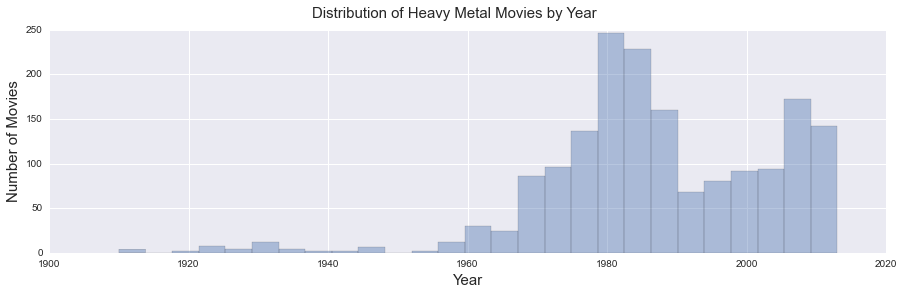

In [7]:
plt.figure(figsize=(15,4)).suptitle('Distribution of Heavy Metal Movies by Year', fontsize='15')
plt.xlabel('Year', fontsize='15')
plt.ylabel('Number of Movies', fontsize='15')
sns.distplot(years, kde=False)

##### Challenge 2
Find the cast member that appeared in most Heavy Metal movies. Is
there one that is shared by more than one of these movies? Or are they
all completely different actors for every movie?


In [1]:
from collections import Counter
import numpy as np
cast = [i['cast'] for i in metal.aggregate([{"$project":{"cast":"$cast"}},{"$unwind":"$cast"}]) if i['cast'] > '']

NameError: name 'metal' is not defined

In [ ]:
pprint(Counter(cast).most_common(10))

##### Challenge 3
Find the most used words in Heavy Metal film titles. Is there a word
that appears in a lot of them? Is it "The"? If it is something like
"the", How can you get around that? Find one "meaningful" word that
appears the most (this means non-structural word, unlike "the" or "a"
or "in")


In [23]:
from nltk import word_tokenize
from nltk.corpus import stopwords 
from bson.son import SON
from bson.code import Code

mapper = Code("""function () {
                 this.title.split(" ").forEach(function(z) {
                    if(z.length > 3)
                   emit(z, 1);
                    });
                }""")


reducer = Code("""function (words, values) {
                    var total = 0;            
                    for (var i = 0; i < values.length; i++) {
                         total += values[i];
                    }
                    return total;
                  }""")
 
result = metal.map_reduce(mapper, reducer, "myresults")

for i in result.find().sort('value', -1).limit(10):
    print i['_id'], i['value']

METAL 58.0
DEAD 46.0
HEAVY 36.0
ROCK 34.0
BLACK 28.0
BLOOD 28.0
LAST 26.0
DEATH 24.0
DEVIL 24.0
NIGHT 24.0



##### Challenge 4
METAL CRED section lists themes included in these movies that makes
them more metal.
What were the top 5 metal cred keywords in the 70s? In 80s? In 90s, In
2000s?


In [24]:
#cred = metal.find({'year':{'$in':range(1970, 1979)}}).collection

def get_aggregate_cred(y1, y2):
    mapper = Code("""function () {
                 this.metal_cred.forEach(function(z) {
                    if(z != 'METAL CRED')
                   emit(z, 1);
                    });
                }""")


    reducer = Code("""function (words, values) {
                    var total = 0;            
                    for (var i = 0; i < values.length; i++) {
                         total += values[i];
                    }
                    return total;
                  }""")


    result = metal.map_reduce(mapper, reducer, "cred", query={'year':{'$in':range(y1, y2)}})
    print('-------------------------------')
    for i in result.find().sort('value', -1).limit(5):
        print i['_id'], i['value']
    print('-------------------------------')
    return {i['_id']: i['value'] for i in result.find().sort('value', -1).limit(5)}

print('1970\'s')
seventies = get_aggregate_cred(1970, 1979)
print('1980\'s')
eighties = get_aggregate_cred(1980, 1989)
print('1990\'s')
nineties = get_aggregate_cred(1990, 1999)
print('2000\'s')
get_aggregate_cred(2000, 2009)

1970's
-------------------------------
Satan 38.0
Black Mass 20.0
Giallo 12.0
Video Nasty 12.0
Manson Family 10.0
-------------------------------
1980's
-------------------------------
Post-Apocalypse 56.0
Sword and Sorcery 38.0
Satan 28.0
Video Nasty 24.0
Zombies 22.0
-------------------------------
1990's
-------------------------------
Gwar 12.0
Satan 12.0
Lemmy 8.0
Alice Cooper 6.0
Iggy Pop 6.0
-------------------------------
2000's
-------------------------------
Torture Porn 16.0
Satan 12.0
Billy Puppet 8.0
Christopher Lee 8.0
Jigsaw 8.0
-------------------------------


{u'Billy Puppet': 8.0,
 u'Christopher Lee': 8.0,
 u'Jigsaw': 8.0,
 u'Satan': 12.0,
 u'Torture Porn': 16.0}

{u'Post-Apocalypse': 28.0, u'Satan': 14.0, u'Zombies': 11.0, u'Sword and Sorcery': 19.0, u'Video Nasty': 12.0}


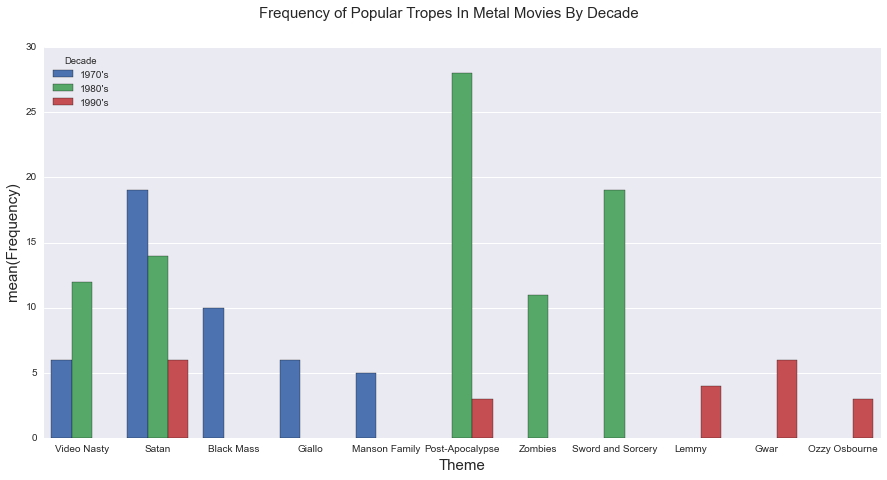

In [494]:
import pandas as pd
print eighties
edf = pd.DataFrame(data={'Theme': eighties.keys(), 'Frequency': eighties.values()})
sdf = pd.DataFrame(data={'Theme': seventies.keys(), 'Frequency': seventies.values()})
ndf = pd.DataFrame(data={'Theme': nineties.keys(), 'Frequency': nineties.values()})
edf['Decade'] = '1980\'s'
sdf['Decade'] = '1970\'s'
ndf['Decade'] = '1990\'s'
df = pd.concat([sdf, edf, ndf])


plt.figure(figsize=(15,7)).suptitle('Frequency of Popular Tropes In Metal Movies By Decade', fontsize='15')
plt.xlabel('Year', fontsize='15')
plt.ylabel('Number of Movies', fontsize='15')
sns.barplot(x="Theme", y="Frequency", hue="Decade", data=df, saturation=1)

##### Challenge 5
Let's use the length of the METAL CRED section as a proxy score for
how metal a movie is. Let's call this the METAL SCORE. To each mongo
document, add the metal_score as a new field.

In [395]:
for i in metal.find():
    metal.update({"_id": i["_id"]},{'$set': {'metal_score': len(i['metal_cred'])}})


In [396]:
#test
scores = [i['metal_score'] for i in metal.find()]
print scores[:10]



[2, 3, 8, 5, 3, 5, 4, 4, 5, 5]


##### Challenge 6
Find the director that is MOST METAL per movie (director with the
highest average metal score).
Remember that some movies have multiple directors.

In [423]:
pipeline = [
    {"$unwind": "$direct"},
    {"$group": {"_id": {"director":"$direct"}, "avg": {"$avg": '$metal_score'}}},
    {"$sort": SON([("avg", -1)])}
    ]
most_metal = list(metal.aggregate(pipeline))
print most_metal[0]


{u'_id': {u'director': u'John Milius'}, u'avg': 75.0}



##### Challenge 7
The majority of directors and actors will have worked on a single
movie. See if there are any directors that worked with an actor more
than once. If so, find the director-actor duo that have worked
together the most times.

In [31]:
import pandas as pd
pipeline = [
    {"$unwind": "$direct"},
    {"$unwind": "$cast"},
    {"$group": {"_id": {"director":"$direct", 'actor': '$cast'}}, 'count': {'$sum': 1}},
    {'$project': {'director' : '$_id.director', 'actor' : '$_id.actor', 'count': 1, '_id': 0}},
    {"$sort": {"count", -1}},
    {'$limit': 5}
    ]

pipeline = [
    {'$unwind': "$direct"},
    {'$unwind': "$cast"},
    {'$group': {'_id': {'director': '$direct', 'actor': '$cast'}, 'count' : { '$sum': 1} } },
    {'$project' : {'director' : '$_id.director','actor' : '$_id.actor', 'count':1 , '_id':1} },
    {'$sort' : {'count': -1 }},
    {'$limit' : 5}
] 

bffs = list(metal.aggregate(pipeline))
pd.DataFrame(bffs)



,_id,actor,count,director
0,"{u'director': u'Joe D’Amato', u'actor': u'Geor...",George Eastman,4,Joe D’Amato
1,"{u'director': u'Rob Zombie', u'actor': u'Sheri...",Sheri Moon Zombie,4,Rob Zombie
2,"{u'director': u'Dario Argento', u'actor': u'Da...",Daria Nicolodi,4,Dario Argento
3,"{u'director': u'Peter Jackson', u'actor': u'Ch...",Christopher Lee,4,Peter Jackson
4,"{u'director': u'Bruce Sinofsky', u'actor': u'J...",Jessie Misskelley,3,Bruce Sinofsky



##### Challenge 8
Create an index on the 'director' field to make the queries involving
it faster.
[What is an index?](http://en.wikipedia.org/wiki/Database_index)

[Creating an index in mongo](http://docs.mongodb.org/manual/tutorial/create-an-index/)
[Creating an index in pymongo](http://api.mongodb.org/python/current/api/pymongo/collection.html?highlight=create_index#pymongo.collection.Collection.create_index)
[Single field index on mongo](http://docs.mongodb.org/manual/core/index-single/)
[Mongo documentation on indexes](http://docs.mongodb.org/manual/core/indexes/)


In [32]:
metal.create_index("direct")

u'direct_1'

In [33]:
for i in metal.list_indexes():
    print i

SON([(u'v', 1), (u'key', SON([(u'_id', 1)])), (u'name', u'_id_'), (u'ns', u'heavy_metal_reviews.h_m')])
SON([(u'v', 1), (u'key', SON([(u'direct', 1)])), (u'name', u'direct_1'), (u'ns', u'heavy_metal_reviews.h_m')])


##### Challenge 9 (Optional challenge for early finishers)
For each decade, make a histogram of metal scores.
Also, calculate the average metal score for each decade. Which decade
was the most pure metal decade?
